# Classification using a 2-Layer Neural Network
Group 23 \
Team Member: Jeffrey Wen \
\
First, import the necessary packages

In [2]:
import torch
import torch.nn as nn
import numpy as np
import sklearn.model_selection as model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt

## Load the data
This code was provided from model_validation.ipynb. There should be 20 features for each sample, 20 classes, and 5000 samples per class.

In [3]:
#Location of the training data
training_folder = 'training_data/'

# instantiate empty arrays for features and labels
Xtr = np.array([])
ytr = np.array([])
k = 0 # initialize

# load data from the relevant files
while True:
    try:
        # load data file
        class_k = np.loadtxt(training_folder + 'Class{:}.csv'.format(k))
        # extract features and labels
        class_k_features = class_k[:,:-1] # extract features
        class_k_labels  = class_k[:,-1].astype(np.int) # labels; convert to int
        
        # append the features and labels to the arrays
        Xtr = np.vstack([Xtr,class_k_features]) if Xtr.size else class_k_features
        ytr = np.hstack([ytr,class_k_labels]) if ytr.size else class_k_labels
        
        # increment counter
        k += 1
    except:
        print('loaded %i classes of training data' %k)
        break

# examine shape
num_classes = k
num_features = Xtr.shape[1]
num_samples = Xtr.shape[0]

print('unique labels: ', np.unique(ytr))
print('number of features: ', num_features)
print('number of samples: ', num_samples)

loaded 20 classes of training data
unique labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
number of features:  20
number of samples:  100000


## Standardize the Data
First, we want to standardize the data. We do this by first finding the sample mean and sample standard deviation for each feature. This prevents the units of the different features from affecting the model. Each feature will have a mean of 0 and variance 1 after the standardization.

In [4]:
#Get the mean and standard deviation of the training data
Xtr_mean = Xtr.mean(axis=0)
Xtr_std = Xtr.std(axis=0)

#Standardize the training data
Xtr_scale = (Xtr - Xtr_mean) / Xtr_std

## Construct the 2-layer Neural Network Class
Here, we define the overall structure of our 2-layer neural network. We will provide inputs for the number of inputs (nin), number of hidden units (nh), number of output units (nout), type of activation function in the hidden layer ('sigmoid','tanh' or 'ReLu'), and options to use batch-norm and dropout.

In [5]:
class Net(nn.Module):
    #Constructor
    def __init__(self,nin,nout,nh,activ_func='sigmoid',batch_norm = False, dropout = False):
        #Inherit the initialization of nn.Module
        super(Net,self).__init__()
        
        #Store the choices as elements of the class
        self.batch_norm = batch_norm
        self.dropout = dropout
        
        #Set the activation to the user specified activation function
        if activ_func == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activ_func == 'tanh':
            self.activation = nn.Tanh()
        else:
            self.activation = nn.ReLU()
            
        #Add a dropout layer if dropout is true
        if dropout == True:
            self.DropoutLayer = nn.Dropout(p=0.5)

            
        #Add a batch norm layer if batch_norm is true
        if batch_norm == True:
            self.BatchNorm = nn.BatchNorm1d(num_features = nh)
        
        
        #Define the layers of the network
        self.dense1 = nn.Linear(nin,nh)
        self.dense2 = nn.Linear(nh,nout)
        
    #Define the forward pass
    def forward(self,x):
        #Pass the input to the first dense layer and activation
        x = self.dense1(x)
        
        #Pass through dropout and/or batch norm if selected
        if self.dropout == True:
            x = self.DropoutLayer(x)
        if self.batch_norm == True:
            x = self.BatchNorm(x)
            
        x = self.activation(x)
            
        #Get the output
        out = self.dense2(x)
        return out
        

# Initialize network to make sure it is set up properly
nh=100
model = Net(nin=num_features, nout=num_classes,nh=nh,activ_func='ReLu',batch_norm=True,dropout=True)

# Print string representation
# print(str(model))
print(str(model))

Net(
  (activation): ReLU()
  (DropoutLayer): Dropout(p=0.5, inplace=False)
  (BatchNorm): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense1): Linear(in_features=20, out_features=100, bias=True)
  (dense2): Linear(in_features=100, out_features=20, bias=True)
)


## Split the data into training and testing data and create dataloaders
We want to perform cross-validation to evaluate how our model will perform on data it was not trained on. We split the dataset into 80% training and 20% testing. Then, to efficiently work with these sets, we create torch dataloaders to handle the batch management of the sets.

In [6]:
#Split the data into testing and training sets with a 20/80 split
X_train,X_test,y_train,y_test = model_selection.train_test_split(Xtr_scale, ytr, test_size = 0.2, shuffle = True)

#Set the batch size for training
batch_size = 100

#Convert the numpy arrays to tensors
Xtr_torch = torch.Tensor(X_train)
ytr_torch = torch.Tensor(y_train)
Xts_torch = torch.Tensor(X_test)
yts_torch = torch.Tensor(y_test)

#Create a training/test dataset from the tensors
train_ds = TensorDataset(Xtr_torch,ytr_torch)
test_ds = TensorDataset(Xts_torch,yts_torch)

#Create a training/test data loader from datasets
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle = True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

## Create a function for training the network
We will be perform a cross validation for several hyperparameters of the network, so here we design a general training function that can be easily called during the cross-validation. We also define a function that can be used to evaluate the accuracy on a given set

In [6]:
#Function to evaluate the accuracy of the model on a given set (training or testing)
def evaluate(model,loader):
    #Check the accuracy
    model.eval()
    
    #Keep track of the number of correct predictions
    correct = 0
    total = 0
    
    #If there is a gpu, use the gpu for the training
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
        model.to(device)

    with torch.no_grad():
        for data in loader:
            #Split the data for this batch
            xtest,ytest = data
            ytest = ytest.type(torch.long)
            
            #If there is a GPU, move the data to the GPU
            if torch.cuda.is_available():
                xtest = xtest.to(device)
                ytest = ytest.to(device)
            
            #Get the predictions for this batch
            ypred = model(xtest)
            _, predicted = torch.max(ypred.data,dim=1)
            total += ytest.size(0)
            correct += (predicted == ytest).sum().item()
         
    #Return the acuuracy
    accuracy = 100*correct/total
    return accuracy
    

#Function to train the model
def train(model,num_epochs,train_loader, lr, test_loader = None,progression=False):
    
    #Set the optimizer and criterion
    opt = optim.Adam(model.parameters(),lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    #If there is a gpu, use the gpu for the training
    if torch.cuda.is_available():
        print('Using GPU')
        device = torch.device('cuda:0')
        model.to(device)
        
    #Keep track of the training and testing accuracy across epochs
    if progression == True:
        tr_acc = []
        ts_acc = []
    
    for epoch in range(num_epochs):
        
        if progression == True:
            tr_acc.append(evaluate(model,train_loader))
            ts_acc.append(evaluate(model,test_loader))
    
        #Put the model in training mode
        model.train()

        for batch,data in enumerate(train_loader):
            #Get the training data for the batch
            x_batch,y_batch = data
            y_batch = y_batch.type(torch.long)
            
            #If there is a GPU, move the data to the GPU
            if torch.cuda.is_available():
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

            #Make a forward pass
            y_pred = model(x_batch)

            #Compute the loss
            loss = criterion(y_pred,y_batch)

            #Find the gradients and backpropagate
            opt.zero_grad()
            loss.backward()

            #Get an optimization step
            opt.step()
            
            
        


    train_acc = evaluate(model,train_loader)
    
    if progression == True:
        return model, train_acc, tr_acc, ts_acc
    
    
    return model, train_acc

    

## Cross Validation 
We would like to perform cross validation to make better decisions about the hyperparameters to use for the final model. Here, we will train and evaluate the model with different number of hidden nodes, different activations, different learning rates, and the use of batch-norm and dropout. Ideally, we would perform cross-validation for every combination of hyperparameters. However, due to limitations in time and resources, we will perform cross validation for each hyperparameter individually. For the next hyperparameter, we will use the hyperparameters that gave the highest test accuracy from the cross-validation tests before it.

### Cross-Validation for Number of Hidden Nodes


In [7]:
num_epochs = 10

#List of number of hidden layers to try
num_hidden = [10,50,100,500,1000]

#Keep track of the train and test accuracies
train_acc = np.zeros(len(num_hidden))
test_acc = np.zeros(len(num_hidden))

for i,nh in enumerate(num_hidden):
    
    #Initialize the model
    model = Net(nin=num_features,nout=num_classes,nh=nh,activ_func='sigmoid',batch_norm = False, dropout = False)
    
    #Train the model
    model, train_acc[i] = train(model,num_epochs,train_loader,lr=0.001)
    
    #Evaluate the model on the test data
    test_acc[i] = evaluate(model,test_loader)
    
    print('# of Hidden Layers: {0:.0f},   Training Accuracy: {1:.2f},    Testing Accuracy: {2:.2f}'.format(nh,train_acc[i],test_acc[i]))
    


Using GPU
# of Hidden Layers: 10,   Training Accuracy: 83.60,    Testing Accuracy: 83.85
Using GPU
# of Hidden Layers: 50,   Training Accuracy: 86.89,    Testing Accuracy: 87.08
Using GPU
# of Hidden Layers: 100,   Training Accuracy: 87.50,    Testing Accuracy: 87.58
Using GPU
# of Hidden Layers: 500,   Training Accuracy: 87.97,    Testing Accuracy: 87.80
Using GPU
# of Hidden Layers: 1000,   Training Accuracy: 88.10,    Testing Accuracy: 88.19


Text(0.5, 1.0, 'Testing Accuracy vs. Hidden Nodes')

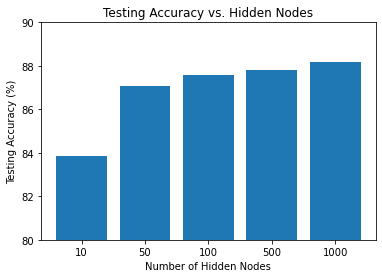

In [8]:
#Plot the testing accuracy of the different number of hidden layers
xvals = []
for i,j in enumerate(num_hidden):
    xvals.append(str(j))
plt.bar(xvals,test_acc)
plt.ylim(80,90)
plt.xlabel('Number of Hidden Nodes')
plt.ylabel('Testing Accuracy (%)')
plt.title('Testing Accuracy vs. Hidden Nodes')


In [9]:
#Use the number of hidden layers with the largest testing accuracy from here on out
nh_idx = np.argmax(test_acc)
nh = num_hidden[nh_idx]
print('Max Accuracy with {0:.0f} Hidden Layer Nodes'.format(nh))

Max Accuracy with 1000 Hidden Layer Nodes


### Cross Validation for Activation Function Type

In [10]:
num_epochs = 10

#List of activation functions to try
act_funcs = ['sigmoid','tanh','ReLu']

#Keep track of the train and test accuracies
train_acc = np.zeros(len(act_funcs))
test_acc = np.zeros(len(act_funcs))

for i,act_func in enumerate(act_funcs):
    #Initialize the model
    model = Net(nin=num_features,nout=num_classes,nh=nh,activ_func=act_func,batch_norm = False, dropout = False)
    
    #Train the model
    model, train_acc[i] = train(model,num_epochs,train_loader,lr=0.001)
    
    #Evaluate the model on the test data
    test_acc[i] = evaluate(model,test_loader)
    
    print('Activation Function: {0},   Training Accuracy: {1:.2f},    Testing Accuracy: {2:.2f}'.format(act_func,train_acc[i],test_acc[i]))
    

Using GPU
Activation Function: sigmoid,   Training Accuracy: 88.27,    Testing Accuracy: 88.11
Using GPU
Activation Function: tanh,   Training Accuracy: 89.38,    Testing Accuracy: 89.14
Using GPU
Activation Function: ReLu,   Training Accuracy: 91.72,    Testing Accuracy: 90.55


Text(0.5, 1.0, 'Testing Accuracy vs. Activation Function')

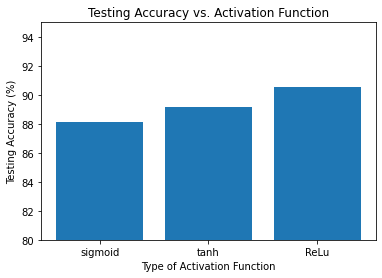

In [11]:
#Plot the testing accuracy of the different activation functions
xvals = []
for i,j in enumerate(act_funcs):
    xvals.append(j)
plt.bar(xvals,test_acc)
plt.ylim(80,95)
plt.xlabel('Type of Activation Function')
plt.ylabel('Testing Accuracy (%)')
plt.title('Testing Accuracy vs. Activation Function')


In [12]:
#Use the activation function with the largest testing accuracy from here on out
act_idx = np.argmax(test_acc)
af = act_funcs[act_idx]
print('Max Accuracy with {0} Activation Function'.format(af))

Max Accuracy with ReLu Activation Function


### Cross Validation for Learning Rate


In [13]:
num_epochs = 10

#List of activation functions to try
learning_rates = [0.1,0.01,0.001, 0.0001]

#Keep track of the train and test accuracies
train_acc = np.zeros(len(learning_rates))
test_acc = np.zeros(len(learning_rates))

#Keep track of the accuracies across epochs for plotting
train_acc_epochs = np.zeros((len(learning_rates),num_epochs))
test_acc_epochs = np.zeros((len(learning_rates),num_epochs))

for i,lr in enumerate(learning_rates):
    
    #Initialize the model
    model = Net(nin=num_features,nout=num_classes,nh=nh,activ_func=af,batch_norm = False, dropout = False)
    
    #Train the model
    model, train_acc[i], train_acc_epochs[i], test_acc_epochs[i] = train(model,num_epochs,train_loader,lr=lr,test_loader=test_loader,progression=True)
    
    #Evaluate the model on the test data
    test_acc[i] = evaluate(model,test_loader)
    
    print('Learning Rate: {0},   Training Accuracy: {1:.2f},    Testing Accuracy: {2:.2f}'.format(lr,train_acc[i],test_acc[i]))
                        
    

Using GPU
Learning Rate: 0.1,   Training Accuracy: 79.02,    Testing Accuracy: 78.78
Using GPU
Learning Rate: 0.01,   Training Accuracy: 90.94,    Testing Accuracy: 89.93
Using GPU
Learning Rate: 0.001,   Training Accuracy: 91.61,    Testing Accuracy: 90.34
Using GPU
Learning Rate: 0.0001,   Training Accuracy: 89.06,    Testing Accuracy: 88.97


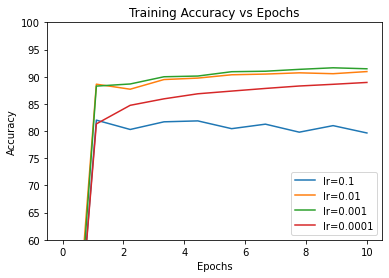

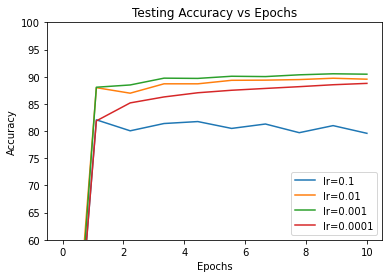

In [14]:
#Plot the progression of the training and testing accuracy across epochs
x = np.linspace(0,num_epochs,num_epochs)
for i,lr in enumerate(learning_rates):
    plt.plot(x,train_acc_epochs[i],label='lr='+str(lr))
    
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(60,100)
plt.title('Training Accuracy vs Epochs')
plt.legend()

#New figure for testing accuracy
plt.figure()
for i,lr in enumerate(learning_rates):
    plt.plot(x,test_acc_epochs[i],label='lr='+str(lr))
    
plt.xlabel('Epochs')
plt.ylim(60,100)
plt.ylabel('Accuracy')
plt.title('Testing Accuracy vs Epochs')
plt.legend()

In [15]:
#Use the learning rate with the largest testing accuracy from here on out
lr_idx = np.argmax(test_acc)
lr = learning_rates[lr_idx]
print('Max Accuracy with {0} for Learning Rate'.format(lr))

Max Accuracy with 0.001 for Learning Rate


### Cross Validation for Use of BatchNorm and Dropout

In [24]:
num_epochs = 10

#List of Batch Norm and Dropout to try
combos = [[True,True],[True,False],[False,True],[False,False]]

#Keep track of the train and test accuracies
train_acc = np.zeros(len(combos))
test_acc = np.zeros(len(combos))

for i,combo in enumerate(combos):
    
    #Initialize the model
    model = Net(nin=num_features,nout=num_classes,nh=nh,activ_func=af,batch_norm = combo[0], dropout = combo[1])
    
    #Train the model
    model, train_acc[i] = train(model,num_epochs,train_loader,lr=lr)
    
    #Evaluate the model on the test data
    test_acc[i] = evaluate(model,test_loader)
    
    print('Batch Norm: {0},    Dropout: {3},   Training Accuracy: {1:.2f},    Testing Accuracy: {2:.2f}'.format(combo[0],train_acc[i],test_acc[i],combo[1]))

Using GPU
Batch Norm: True,    Dropout: True,   Training Accuracy: 89.27,    Testing Accuracy: 88.55
Using GPU
Batch Norm: True,    Dropout: False,   Training Accuracy: 90.62,    Testing Accuracy: 89.67
Using GPU
Batch Norm: False,    Dropout: True,   Training Accuracy: 91.36,    Testing Accuracy: 90.69
Using GPU
Batch Norm: False,    Dropout: False,   Training Accuracy: 92.05,    Testing Accuracy: 90.81


Text(0.5, 1.0, 'Testing Accuracy vs. Batch Norm and Dropout Additions')

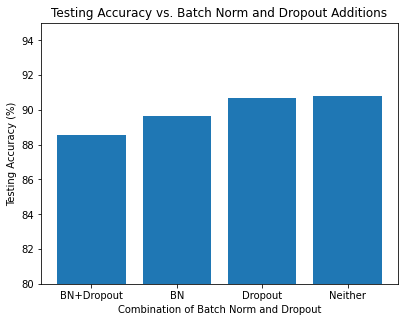

In [30]:
#Plot the testing accuracy of the different inclusions of batch norm and dropout
xvals = ['BN+Dropout', 'BN', 'Dropout', 'Neither']
plt.bar(xvals,test_acc)
plt.ylim(80,95)
plt.xlabel('Combination of Batch Norm and Dropout')
plt.ylabel('Testing Accuracy (%)')
plt.title('Testing Accuracy vs. Batch Norm and Dropout Additions')



In [29]:
#Use the configuration of batch norm and dropout with the best accuracy
val_idx = np.argmax(test_acc)
BNDP = combos[val_idx]
print('Max Accuracy with Batch Norm: {0},  Dropout: {1}'.format(BNDP[0],BNDP[1]))

Max Accuracy with Batch Norm: False,  Dropout: False


## Confusion Matrix
For the network with the highest test accuracy, we would like to see the confusion matrix to see what categories the network does well on and which networks it struggles with

In [18]:
#Train the model with the best performing hyperparameters from each of the cross validations
model = Net(nin=num_features,nout=num_classes,nh=nh,activ_func=af,batch_norm = BNDP[0], dropout = BNDP[1])
model, train_acc = train(model,num_epochs,train_loader,lr=lr)

#Evaluate the model on the test data
test_acc = evaluate(model,test_loader)

#Check the confusion matrix
model.eval()

#Initialize the confusion matrix
C = np.zeros((num_classes,num_classes))

#If there is a gpu, use the gpu for the training
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    model.to(device)

with torch.no_grad():
    for data in test_loader:
        #Split the data for this batch
        xtest,ytest = data
        ytest = ytest.type(torch.long)

        #If there is a GPU, move the data to the GPU
        if torch.cuda.is_available():
            xtest = xtest.to(device)
            ytest = ytest.to(device)

        #Get the predictions for this batch
        ypred = model(xtest)
        _, predicted = torch.max(ypred.data,dim=1)

        #Find the performance metrics
        C = C + confusion_matrix(ytest.cpu().numpy(),predicted.cpu().numpy(),labels=np.unique(ytr))



Using GPU


Training Accuracy: 91.70,    Testing Accuracy: 90.40


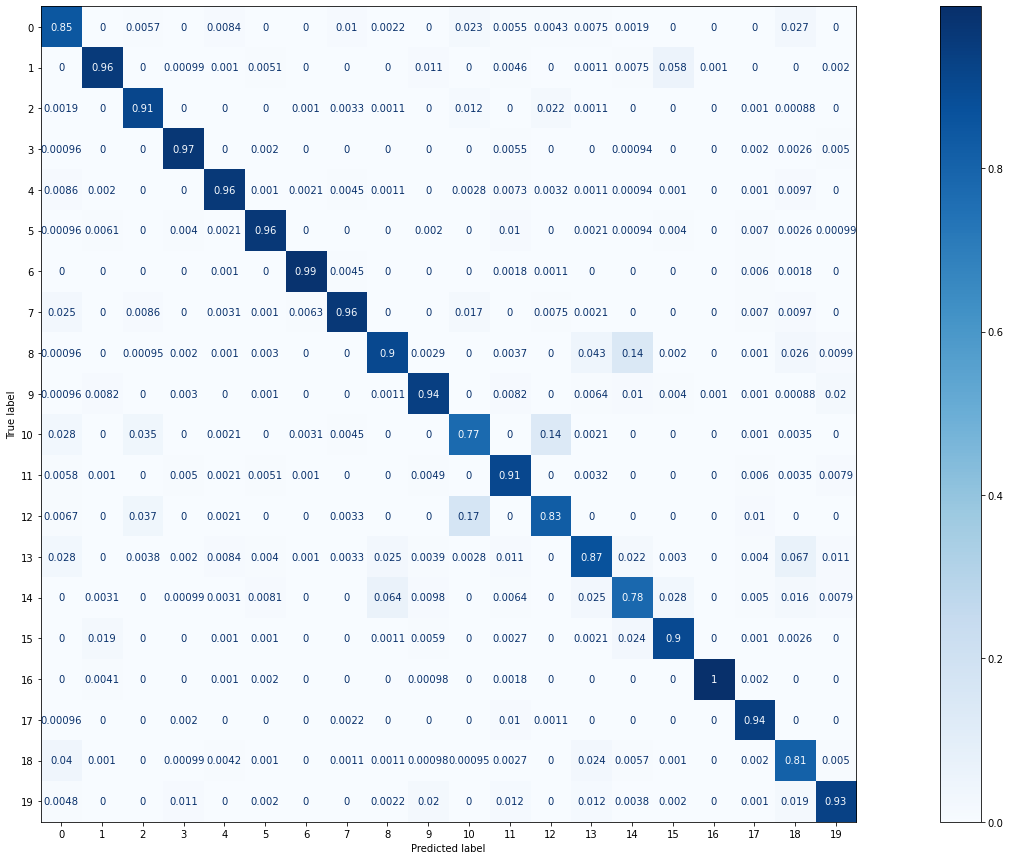

In [21]:
#Normalize the confusion matrix
col_totals= C.sum(axis=0)
C = C/col_totals        
        
#Print the confusion matrix and performance
print('Training Accuracy: {0:.2f},    Testing Accuracy: {1:.2f}'.format(train_acc,test_acc))
#print(np.array_str(C, precision=4, suppress_small=True))
plt.rcParams['figure.figsize'] = [30, 15]
conf_matrix_plot = ConfusionMatrixDisplay(C)
conf_matrix_plot.plot(cmap=plt.cm.Blues)

## Final Network
After using cross-validation to select the hyperparameters, we would like to train a final network using all the training data.

In [7]:
#Convert the numpy arrays to tensors
Xall_torch = torch.Tensor(Xtr_scale)
yall_torch = torch.Tensor(ytr)

#Create a training dataset from the tensors
trainall_ds = TensorDataset(Xall_torch,yall_torch)

#Create a trainingdata loader from dataset
trainall_loader = DataLoader(trainall_ds, batch_size=batch_size, shuffle = True)

#Train the model with the best performing hyperparameters from each of the cross validations
model = Net(nin=num_features,nout=num_classes,nh=nh,activ_func=af,batch_norm = False, dropout = False)
model, train_acc = train(model,num_epochs,trainall_loader,lr=lr)

#Show final training accuracy
print('Training Accuracy with all Training Data: {0:.2f}'.format(train_acc))


#Save the pytorch model by saving the trace with a random input
x = torch.randn(num_features) # random input
x = x[None,:] # add singleton batch index
#if torch.cuda.is_available():
#    x = x.to(device)

with torch.no_grad():
    traced_cell = torch.jit.trace(model, (x))
torch.jit.save(traced_cell, "./saved_model2NN.pth")

#Check to make sure the save gives the same output
# original model:
with torch.no_grad():
    out = model(x)
print(out)

# reloaded model:
model2 = torch.jit.load("./saved_model2NN.pth")
with torch.no_grad():
    out2 = model2(x)
print(out2)

tensor([[-23.5806,   1.9387, -65.6126,  -5.0830, -18.9617,  -2.1801, -50.0816,
         -43.0744,  -9.0681,  -5.3055, -34.5046,  -9.3136, -60.2520,   2.0563,
           7.3639,   3.5719, -16.0256, -41.2564, -15.7787,   1.2581]])
tensor([[-23.5806,   1.9387, -65.6126,  -5.0830, -18.9617,  -2.1801, -50.0816,
         -43.0744,  -9.0681,  -5.3055, -34.5046,  -9.3136, -60.2520,   2.0563,
           7.3639,   3.5719, -16.0256, -41.2564, -15.7787,   1.2581]])


/home/jeff/anaconda3/envs/tfpy/lib/python3.7/site-packages/torch/jit/__init__.py:852: UserWarning: The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is.
  warnings.warn('The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is.')
